<h1 style="text-align: center;">Investigating the 2013-2014 marine heatwave in the North-East Pacific</h1>

Towards the end of 2013 a large and apparently growing mass of warm water formed in the North-Eastern Pacific ocean. By 'warmer', I mean the sea water temperature was a few degrees away from the temperatures expected of the region at that time of year. 

This was also considerably warmer the year-on-year warming caused by a globally warming climate. 

The mass was named "The Blob" by Nick Bond, a climate scientist in the University of Washington - who decided to give a nod to the 1958 horror film of that name. It's about an unstoppable mass that keeps growing and destroys everything in it's path. Subtle.

<table><tr>
<td> <img src="figures_used/0201newsfeature_pacificblob_globe5.jpg" alt="Drawing" style="width: 400px; height: 383px"/> </td>
<td> <img src="figures_used/The_Blob_(1958)_theatrical_poster.jpg" alt="Drawing" style="width: 250px; height:"/> </td>
</tr></table>

At it's peak, the anomaly stretched from the Gulf of Alaska to Baja California. The immediate, and medium term, impacts were severe -  including mass die-offs of seabirds and marine mammals, toxic phytoplankton blooms, and the near-collapse of several important fisheries.

### Getting used to Python - a very brief introduction

Different fields in science often adopt different tools, even when they all broadly do the same thing. In oceanography it is now common to work in Python, so many of the computational tools available to us are written in Python. But as most of you will not have used it yet, I thought it would be useful just to give a short overview of the main features you need to know about here. I'll also point out a few things you should when using IPython notebooks like this. 

First off, this notebook is composed of cells. Each box you can see is a cell, and you can run the code in them independently of one another, or run them all at once. 

This cell is a markdown cell. What does that mean? Markdown is a kind of coding language to "just write things", such as this text. The cell below is a code cell, which can actually execute commands.

A final introductory thing: If you're stuck, or the notebook is acting in a way that seems odd - just restart it. You will need to re-run all the cells you previously ran.


In [2]:
# loading modules

# In Python, when we need a particular module we load using an 'import' statement, usually at the beginning of the notebook/script.
# for example, the Python numerical module numpy:
import numpy as np

# I've also given this import an alias with the 'as' statement. This means we can use a short name to call a module with a long 
# name.
np

<module 'numpy' from 'C:\\Users\\uv20102\\Anaconda3\\envs\\CMIP6_field_analysis_env\\lib\\site-packages\\numpy\\__init__.py'>

But if we want to do anything, we also need to define **variables**,

In [3]:
# variables - an object that can take on different values, types ect. That we can also do things to

# for example:
var_a = 17
# so var_a is just the number 17
var_a

17

In [4]:
# or if we do things to it 
((var_a ** 2) / 7.2) + 21.432
# but this WON'T be preserved, if you want to hold on to this answer you will need to define a new variable
# to accept that answer.

61.57088888888889

In [5]:
var_b = ((var_a ** 2) / 7.2) + 21.432
var_b

61.57088888888889

It's useful to have reusable code, so for that we use **functions**. Once they're defined, you can reuse them anywhere in the notebook, or even import them for elsewhere like a module.

In [6]:
# functions - you can recognise them as we use a 'def' statement to define them
# if we use the above as an example,

def astonishing_func(input_var):
    output_var = ((input_var ** 2) / 7.2) + 21.432
    return output_var

# which means we can do this,
astonishing_func(var_a)


61.57088888888889

But everytime a variable is defined, function made, or operation performed we use memory. So if you have a large amount of data to process, you can run into memory errors. A notebook-hygiene technique, is to clean things up as you go, 

In [7]:
# Cleaning things up
# if you want to permanently delete a variable or function, use del
del var_b, astonishing_func

In [8]:
# so now var_b will be undefined, because we nuked it from the notebook..
var_b

NameError: name 'var_b' is not defined

In [ ]:
# A note on types
# You will notice that the code text is a lot of different colours - this is one the ways the notebook differentiates 
# between 'types', different kinds of code object, which are the basic building blocks of python
# the main things I want you to recognise are:

# Strings - text basically, if you see '' or "" around domething, its a string
a_nice_string = "whose name is bob"
a_nice_string

In [ ]:
# And various kinds of numbers.
# If a number has a decmial point in it, its a 'float', like,
floaty_num = 2.34
# but if it doesn't it's an integer, or 'int' type
int_num = 2

# if you're unsure what something is, you can use the type() function, like this
type(int_num)

And finally you should know that in IPython notebooks, anything you have called, imported or defined is **"defined globally"**. This means that the thing you just defined can be 'seen' by any other process in the notebook, it doesn't matter which cell that process is in. This is useful, because you don't need to re-run the whole notebook each time you do something, but it means you have to **be careful when you start editing/changing things**

### Part 1: Loading the ECCO data 

I have given you more data than I will use in these examples - but part of this practical's purpose is for you to see how these variables behave in the 'real' world. **So try using the methods shown here on other variables**. Their names are a bit odd, but there is a list of most of them in `list_of_ECCO_variable_names.txt`, this has also got their units, long names and a bit of additional info.

In [2]:
# the things you'll need
import os
import sys
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import warnings
import ecco_v4_py as ecco
import gc
from dask.distributed import Client

# If you click on this url, you will end up on the dask dashboard - what is it? It shows you which python processes 
# are running at a given time, how much memory they're using and their progress.
client = Client()
client.run(gc.collect)
client

C:\Users\uv20102\Anaconda3\envs\CMIP6_field_analysis_env\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62193 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:62193/status,
Dashboard: http://127.0.0.1:62193/status,Workers: 4
Total threads: 12,Total memory: 15.61 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62194,Workers: 4
Dashboard: http://127.0.0.1:62193/status,Total threads: 12
Started: Just now,Total memory: 15.61 GiB
Comm: tcp://127.0.0.1:62222,Total threads: 3
Dashboard: http://127.0.0.1:62223/status,Memory: 3.90 GiB
Nanny: tcp://127.0.0.1:62198,


In [3]:
# just the directories where the data should live
ecco_data_dir = 'D:/ECCOv4_heat_transport/ECCO_V4r4/ECCO_data/atmos_and_flux_data_1992_2017.nc' #'./ECCO_data/'
grid_dir = './grid_dir/GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc'

#### Also introducing xarray, a handy python tool 

Xarray is very useful for storing and analysing spatial data, like the ECCO dataset. It has all sort's of features, which you are free to explore! But mostly I will say in the comments what is going on an why.

There are two important features I want to mention here first: 1) xarray use indices to organise its data. These are postions along a dimension, say time. For example, if I had an 3D array of data (i.e. it has X, Y and Z coordinates), then I could pick a point out of that array by selecting a point in each of the dimensions (i.e. X=3, Y=6, Z=4).

Xarray can do that, but for many dimensions - I will point out when I do this. Do alter and edit the code if you feel like it, if something goes terribly wrong, you can just download a new version of the notebook. 

In [4]:
%%time 
# atmosphere and sea surface flux data
atmos_ds = xr.open_dataset(ecco_data_dir)
# ocean transport data
# otrans_ds = 
# density and stratification
# strat_ds = 

CPU times: total: 1.41 s
Wall time: 11.9 s


In [17]:
# the ecco grid - this is used for various calculations, anything involving area, volume, distance ect
grid = xr.open_dataset(grid_dir)

#### Setting up some constant values

In [6]:
# this is the volume of each grid cell. the dataset is the same shape as the variables that 'need', heat transport terms for example,
# so you can multiply and divide other datasets and dataarrays by it
# vol = (grid.rA*grid.drF*grid.hFacC).transpose('tile','k','j','i')

In [7]:
# Seawater density (kg/m^3)
# rhoconst = 1029
# ## needed to convert surface mass fluxes to volume fluxes

# # Remember this? Heat capacity (J/kg/K)
# c_p = 3994

# # Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
# R = 0.62
# zeta1 = 0.6
# zeta2 = 20.0

In [8]:
# some functions I'll use occasionally
def plot_a_map(da, grid, vmin=None, vmax=None, cmap=None):
    
    p = ecco.plot_proj_to_latlon_grid(grid.XC, grid.YC, da,
                                      show_colorbar=True,
                                      user_lon_0=-130, user_lat_0=None,
                                      dx=0.5, dy=0.5,
                                      cmap=cmap, 
                                      vmin=vmin, vmax=vmax, cmin=vmin, cmax=vmax,
                                      #subplot_grid=[3,1,idx+1]
    )

### Part 2: The surface temperature (atmosphere and ocean) 

A climatology is basically a long-term average - which is useful to compare 'anomalies' against. We aren't going to think much about how an properly define an anomaly today (it can get a bit involved..), for our purposes its just **a difference from the climatology**. Or, a difference from some kind of mean state.

Below, you will see an example of how to do a weighted average. Youn need to do this because we are using monthly mean data, and different months are different lengths (30 vs 31 vs 28 days).

In [19]:
### !!! SOMETHING YOU CAN EDIT !!!
variable = 'EXFatemp' # this is surface air temperature, but check the list for others
X_point = 50
Y_point = 80
tiles=[7,10]

# this is what a dataset looks like - theres a lot of information in these
atmos_ds

<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, tile: 2, time: 312, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 7 10
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
    ...         ...
    YC         (tile, j, i) float32 67.47 67.34 67.16 ... 12.42 11.44 10.46
    XG         (tile, j_g, i_g) float32 142.0 142.0 142.0 ... -39.0 -39.0 -39.0
    YG         (tile, j_g, i_g) float32 67.5 67.4 67.25 ... 12.91 11.93 10.95
    time_bnds  (time, nv) datetime64[ns] 1992-01-01T12:00:00 ... 2017-12-31T1...
    XC_bnds    (tile, j, i, nb) float32 142.0 142.0 142.4 ... -39.0 -38.0 -38.0
    YC_bnds    (tile, j, i, nb) float32 67.5 67.4 67.43 ... 9.97 9.97 10.95
Dimensions without coordinates: nv, nb
Data variables:
    EXFatemp   (time, tile, j, i) float32 ...
    EXFaqh     (time, tile, j, i) float32 ...
    EXFuwind   (time, tile, j, i) float32 ...
    EXFvwind   (time, tile, j, i) float32 ...
    EXFwspee   (time, tile, j, i) float32 ...
    EXFpress   (time, tile, j, i) float32 ...
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Atmosphere Surface Temperature, Humidi...
    uuid:                         70b3d882-400d-11eb-9907-0cc47a3f49c3

In [10]:
# I'll take this opportunity to explain the dataset dimensions
# A dataarray is a single variable, like sea surface pressure - the dataset is composed of one or many arrays
# these arrays have dimensions, like x, y, z and time, which allow us to organise them.
# If you want to know a dataset's or a dataarray's dimensions just do this
atmos_ds.dims

Frozen({'i': 90, 'i_g': 90, 'j': 90, 'j_g': 90, 'tile': 2, 'time': 312, 'nv': 2, 'nb': 4})

In [11]:
# This is a method of xarray's, you can group data along some dimension, like time. So here I'm just gouping the data
# by year, then find the start and end time points to cut out the period we will use as the climatology
years = atmos_ds.groupby('time.year').groups
climatology_range = [i for i in list(years.keys()) if i <= 2011]


inds = []
for y in climatology_range:
    inds.append(years[y])
# this is just a pythony thing... if you're interested feel free to ask, otherwise don't worry 
# about it
rng = [i for sl in inds for i in sl]
climatology_start_end = slice(np.min(rng), np.max(rng)+1)


In [12]:
# these are just the number of days in a given month. I though we might as well do the ave
clim_mon_len = atmos_ds.time.dt.days_in_month.isel(time=climatology_start_end)

In [13]:
# This is how we cut out a section of data we want to do somthing with, so in this case the start and end index
# of the climatology period, 1992 to 2011
ecco_1992_2011 = atmos_ds.isel(time=climatology_start_end)

In [14]:
# we calculate the weights for averaging
weights = (
    clim_mon_len.groupby("time.month") / clim_mon_len.groupby("time.month").sum()
)

# And this is the climatology - CRUCIALLY not including the period we might want to compare it 
monthly_climatology = (ecco_1992_2011*weights
                       ).groupby('time.month').sum(dim='time'
)
monthly_climatology.month.values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

-179.75 49.75
-180.0 50.0
-89.75 89.75
-90.0 90.0
50.250975231660234 179.74903476833975
50.00001 180.0
-89.75 89.75
-90.0 90.0


C:\Users\uv20102\Anaconda3\envs\CMIP6_field_analysis_env\lib\site-packages\cartopy\crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\uv20102\Anaconda3\envs\CMIP6_field_analysis_env\lib\site-packages\cartopy\crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
C:\Users\uv20102\Anaconda3\envs\CMIP6_field_analysis_env\lib\site-packages\cartopy\crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings =

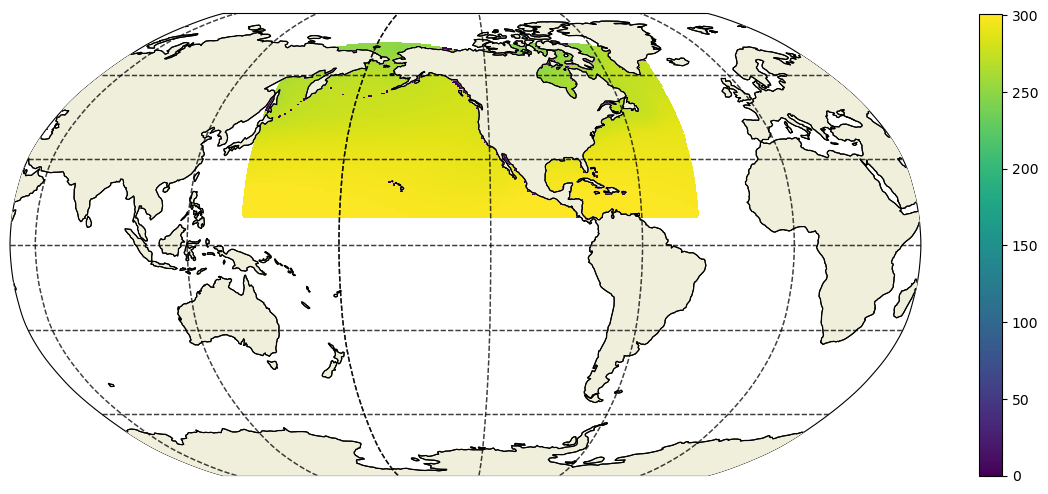

In [20]:
# As an example, here is sea level pressure December 2012
dec_climatology_press = monthly_climatology[variable].sel(month=12
                                                            ).assign_attrs(
    {'units':atmos_ds[variable].units}
)

plt.figure(figsize=(15, 6))

p = plot_a_map(
    dec_climatology_press,
    grid.isel(tile=tiles),
    # vmax=102200,
    # vmin=100000,
)

In [21]:
# plotting a time series - lets use tile 7 as its mostly open ocean
# and for the moment, lets pick surface air temperature

air_temp_7 = atmos_ds[variable].sel(tile=7)

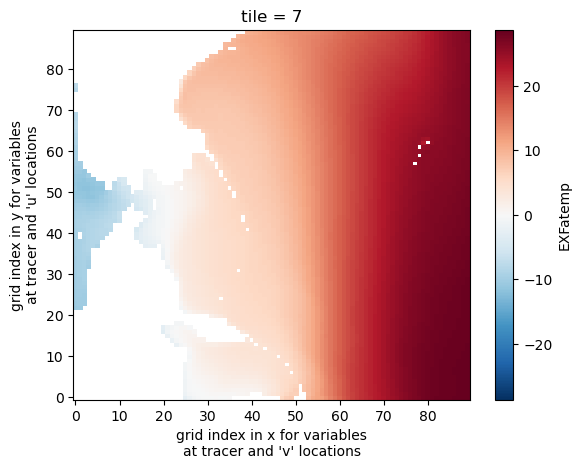

In [24]:
# although if we just plot it, it's at a funny orientation
air_temp_degC.mean(dim='time').plot()

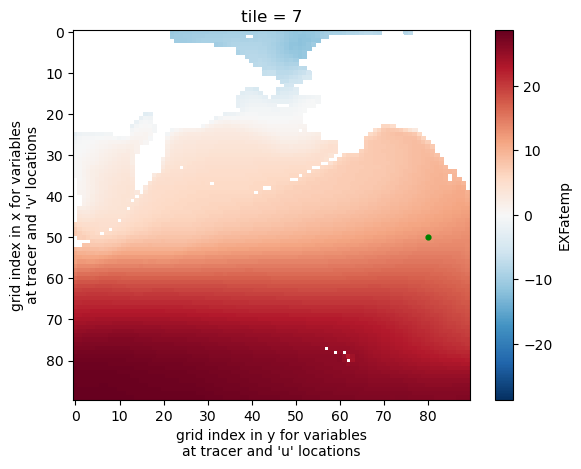

In [22]:
# Always check the units! This converts temperature to celsius if its in degrees Kelvin
air_temp_degC = (air_temp_7 - 272.15).assign_attrs({'units':'Deg C'})
# because its at a weird angle, the commands inside plot() just turn it the right way around
air_temp_degC.mean(dim='time').plot(x='j', yincrease=False)

# and a random point that I thought seemed nice - Note: I have swapped things around
j, i = X_point, Y_point

plt.scatter(j, i, s=12, color='green')

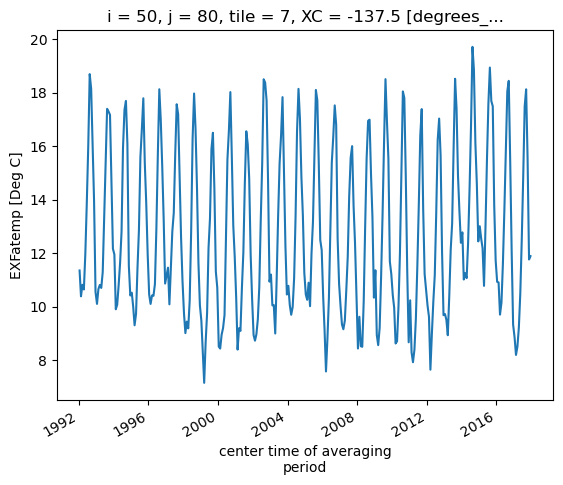

In [23]:
# we can plot things in terms of lat and lon... but its a bit of a pain, so we're just going to use the indices
# what's going on at that point?
air_temp_degC.isel(j=j, i=i).plot()

In [ ]:
air_temp_anom = (air_temp_degC - air_temp_degC.mean(dim='time')).groupby('time.year').mean(dim='time')
air_temp_anom

In [ ]:
air_temp_anom.isel(i=i, j=j).plot()

In [ ]:
# So whats going around the point?
air_temp_anom.sel(year=2015).plot(x='j', yincrease=False)
plt.scatter(j, i, s=12, color='green')

### *take-away questions*
- Which year seems to have the most extreme values?
- What happened to the (atmospheric) surface temperature of this region during 'The Blob' period? How might you show this?
- In general, the atmosphere drives the surface ocean, so what might you expect to happen to the vertical structure of the seawater given the information you have just seen?

### Part 4: What was the ocean doing?

In [ ]:
# Do the same thing for the ocean transport terms.
# How do these compare to the surface fluxes? Which are the most important at this location?


### *take-away questions*

- What is the heat budget?...
- Which of the terms you have seen above is usually the most important in the North East Pacific? Can you think of a simple way of showing that?

### Part 5: 

This bit is up to you!

Look at the previous bits of code, and have a think about how you could edit them to do your own analysis. **This will be very important for your report**. You don't need to re-write everything, but try picking different variables and seeing if you can build a case for this extreme event being present in them.